## Install dependencies on google colaborate

In [0]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update

apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev

# Lua binding dependencies
apt-get install liblua5.1-dev



## Install necessary libraries




In [0]:
!pip install git+https://github.com/mwydmuch/ViZDoom

  Cloning https://github.com/mwydmuch/ViZDoom to /tmp/pip-req-build-4sb_j3kk
  Running command git clone -q https://github.com/mwydmuch/ViZDoom /tmp/pip-req-build-4sb_j3kk
  Created wheel for vizdoom: filename=vizdoom-1.1.8-cp36-none-any.whl size=14461301 sha256=feeb79c6e7878df359cdcdb8d875a467aa2c33d56c31a40dab4551ff6e3be160
  Stored in directory: /tmp/pip-ephem-wheel-cache-expkp0av/wheels/83/3f/ae/4b946ae45795f2064ff1270f67f8379e22485bd0bf80b37ab0
Successfully built vizdoom


In [0]:
from keras.models  import Sequential
from keras.layers  import Conv2D
from keras.layers  import Activation   # Deep Learning library
from keras.layers  import Dense
from keras.layers  import Dropout
from keras.layers  import Flatten
from keras.constraints import maxnorm
from keras.optimizers import Adam
from keras.models import load_model
import numpy as np           # Handle matrices
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames
from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs
from __future__ import print_function
import vizdoom as vzd
import cv2
from random import choice,uniform,randint,sample
from time import sleep
from sklearn.metrics import mean_squared_error as mse

Using TensorFlow backend.


In [0]:
def plot_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel("score")
    plt.ylabel("episodes")
    plt.show()
    plt.close()

In [0]:
def plot_mse(train,test):
    plt.plot(train)
    plt.plot(test)
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('batch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(loss):
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch')
    plt.show()

In [0]:
def buildmodel_initial(shape):
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=shape,activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3) , padding='same',activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Activation('relu'))
    model.add(Dense(3,activation='softmax'))
   
    adam = Adam(lr=1e-6)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [0]:
def buildmodel_improved(shape):
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=shape,activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
    model.add(Conv2D(64, (3, 3) , padding='same',activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Activation('relu'))
    model.add(Dense(3,activation='softmax'))
   
    adam = Adam(lr=1e-6)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [0]:
def save_model(model,f):
    model.save(f)

In [0]:
def show_image(img,title):
    f,ax = plt.subplots(1,1,figsize=(8,3))
    ax.imshow(img)
    f.suptitle(title)
    plt.show()

In [0]:
def preprocess_image(img,shape):
    im = cv2.resize(img,(shape[0],shape[1]))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im

In [0]:
def create_doom_instance():
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("usr/local/lib/python3.7/dist-packages/vizdoom/scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path("/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.wad")

    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(True)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(True)  # Smoke and blood
    game.set_render_messages(True)  # In-game messages
    game.set_render_corpses(True)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(100)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(20)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()
    return game

In [0]:
def run_game_iteration(game,last_states,episode,observation_episodes,replay_memory,actions,shape,episodes,epsilon,policy_network):
    s_0 = np.array(last_states)
            
    last_states.pop(0)
            
    action = choose_action(actions,epsilon,shape,policy_network,s_0,observation_episodes,episode)
            
    r = game.make_action(actions[action])

    _,s = get_curr_state(game,shape)
            
    last_states.append(s)

    s_1 = np.array(last_states)

    terminal = game.is_episode_finished()

    state = (s_0,action,r,s_1,terminal)
            
    replay_memory.append(state)

In [0]:
def run_game_iterations(game,actions,epsilon,shape,episodes,policy_network):
    
    replay_memory = list()
    rewards = list()
    observation = 0
    epsilon = 1

    for episode in range(episodes):
      
      game.new_episode()

      last_states = list()
          
      _,s = get_curr_state(game,shape)

      for _ in range(shape[2]):
          last_states.append(np.array(s))
          
      while not game.is_episode_finished():
        run_game_iteration(game,last_states,episode,episodes,replay_memory,actions,shape,episodes,epsilon,policy_network)
      
      rewards.append(game.get_total_reward())

    return (sum(rewards)/len(rewards),replay_memory)

In [0]:
def get_sample_plays(game,actions,shape,episodes,policy=None):
    _,samples = run_game_iterations(game,actions,0,shape,episodes,policy)
    return samples

def run_tests(game,actions,shape,episodes,policy):
    statistics,_ = run_game_iterations(game,actions,1,shape,episodes,policy)
    return statistics

In [0]:
def epsilon_greedy(epsilon,rewards):
    r = uniform(0,1)
      
    if(epsilon <= r):
      return randint(0,len(rewards) - 1)
      
    m = np.argmax(rewards)
      
    return m

In [0]:
def choose_action(actions,epsilon,shape,policy,state,observation,episode):
    if episode < observation:
      return randint(0,len(actions) - 1)
    else:
      inputs = np.reshape(state,(-1,shape[0],shape[1],shape[2]))
      rewards = policy.predict(inputs)      
      return epsilon_greedy(epsilon,rewards)

In [0]:
def get_curr_state(game,shape):
    
    if game.is_episode_finished():
      return (None,None)

    state = game.get_state()
    n = state.number
    screen_buf = state.screen_buffer
    preprocessed_image = preprocess_image(screen_buf,shape)/255
    
    return (n,preprocessed_image)

In [0]:
def get_minibatch(policy_network,target_network,replay_memory,batch,shape,actions,epsilon,gamma):
    minibatch = sample(replay_memory,batch)

    inputs = np.zeros((batch,shape[0],shape[1],shape[2]))
    targets = np.zeros((batch,len(actions)))
    
    for i in range(batch):
      state_t0 = minibatch[i][0]
      action_t0 = minibatch[i][1]
      reward_t0 = minibatch[i][2]
      state_t1 = minibatch[i][3]
      terminal = minibatch[i][4]

      inputs[i:i+1] = np.reshape(state_t0,(-1,shape[0],shape[1],shape[2])) 

      state_t0_input = np.reshape(state_t0,(-1,shape[0],shape[1],shape[2])) 
      targets[i] = policy_network.predict(state_t0_input)
      
      if terminal:
        targets[i,action_t0] = reward_t0        
      else:
        state_t1_input = np.reshape(state_t1,(-1,shape[0],shape[1],shape[2])) 
        Qsa = target_network.predict(state_t1_input)
        targets[i,action_t0] = reward_t0 + gamma* np.max(Qsa)

      return (inputs,targets)

In [0]:
def train_model_minibatch(policy_network,target_network,replay_memory,val_memory,batch,
                          shape,actions,epsilon,gamma,train_history,val_history,loss_history):
    
      train_inputs,train_targets = get_minibatch(policy_network,target_network,replay_memory,batch,shape,actions,epsilon,gamma)
      val_inputs,val_targets =   get_minibatch(policy_network,target_network,val_memory,batch,shape,actions,epsilon,gamma)   
    
      loss = policy_network.train_on_batch(train_inputs,train_targets)
      
      train_predicts = policy_network.predict(train_inputs)
      val_predicts =  policy_network.predict(val_inputs)
      
      train_mse = mse(train_targets,train_predicts)
      val_mse = mse(val_targets,val_predicts)
      
      train_history.append(train_mse)
      val_history.append(val_mse)
      loss_history.append(loss)

      ##print(f"batch loss {loss}")

In [0]:
def deepQlearning(game,actions,shape,episodes,observation_episodes,update_target,target_update_frequency,epsilon,gamma,batch,buildmodel,model=None):
    

    if model != None:
      policy_network = model
      target_network = buildmodel(shape)
      target_network.set_weights(target_network.get_weights())
    
    else:
      policy_network = buildmodel(shape)
      target_network = buildmodel(shape)

    train_history = list()
    val_history = list()
    loss_history = list()

    rewards = list()
    
    replay_memory = list()
    val_memory = get_sample_plays(game,actions,shape,episodes)

    for episode in range(episodes):
        print("Episode #" + str(episode + 1))


        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()
        
        last_states = list()
        
        _,s = get_curr_state(game,shape)

        for _ in range(shape[2]):
            last_states.append(np.array(s))
        
        while not game.is_episode_finished():
            run_game_iteration(game,last_states,episode,observation_episodes,replay_memory,actions,shape,episodes,epsilon,policy_network)

            if episode >= observation_episodes:
              train_model_minibatch(policy_network,target_network,replay_memory,val_memory,batch,
                                    shape,actions,epsilon,gamma,train_history,val_history,loss_history)

            # Prints state's game variables and reward.
            # print("State #" + str(n))
            # print("Game variables:", vars)
            # print("Reward:", r)
            # print("=====================")
            print("-",end="")
        
        if episode >= update_target and ((episode - update_target) % target_update_frequency) == 0:
          target_network.set_weights(policy_network.get_weights())

        # Check how the episode went.
        print("Episode finished.")
        print("Total reward:", game.get_total_reward())
        print("************************")
        
        rewards.append(game.get_total_reward())
      

    return (policy_network,rewards,train_history,val_history,loss_history)


Now we build the model
We finish building the model
Now we build the model
We finish building the model
Episode #1
----------------------------------------------------------------------------------------------------Episode finished.
Total reward: -125.0
************************
Episode #2
------------------------------------------------Episode finished.
Total reward: 43.0
************************
Episode #3
----------------------------------------------------------------------------------------------------Episode finished.
Total reward: -130.0
************************
Episode #4
----------------------------------------------------------------------------------------------------Episode finished.
Total reward: -125.0
************************
Episode #5
--------------------------Episode finished.
Total reward: 70.0
************************
Episode #6
----------------------------------------------------------------------------------------------------Episode finished.
Total reward: -125.0
*

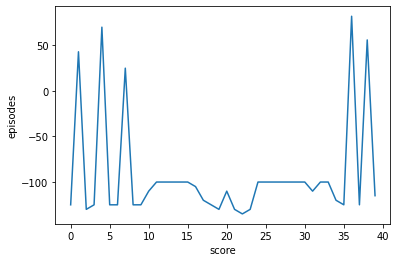

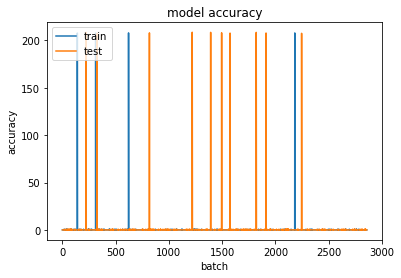

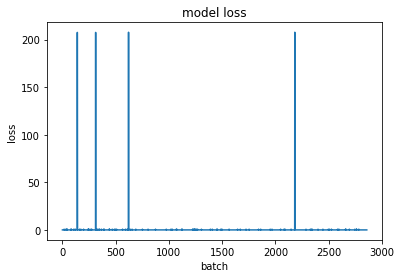

In [0]:
def main():
    # Create DoomGame instance. It will run the game and communicate with you.
    game = create_doom_instance()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 40
    epsilon = 1
    gamma = 0.5
    batch = 16
    target_update_frequency = 1
    observation_episodes = 10
    shape = (64,64,4)
    update_target = observation_episodes + 1
    model_loc = "policy_network.h5"

    ##model = load_model(model_loc)
    model,rewards,train_history,val_history,loss_history = deepQlearning(game,actions,shape,episodes,observation_episodes,
                                  update_target,target_update_frequency,epsilon,gamma,batch,buildmodel_initial)  
    
    print(rewards)
    plot_rewards(rewards)
    plot_accuracy(train_history,val_history)
    plot_loss(loss_history)
    
    

    model.save(model_loc)
    # It will be done automatically anyway but sometimes you need to do it in the middle of the program...
    game.close()

if __name__ == "__main__":
    main()

In [0]:

vizdoom.__version__

In [0]:
!ls "/usr/local/lib/python3.6/dist-packages/vizdoom/scenarios/basic.wad"

basic.cfg	       defend_the_line.cfg	     my_way_home.cfg
basic.wad	       defend_the_line.wad	     my_way_home.wad
cig.cfg		       health_gathering.cfg	     oblige.cfg
cig.wad		       health_gathering_supreme.cfg  predict_position.cfg
cig_with_unknown.wad   health_gathering_supreme.wad  predict_position.wad
deadly_corridor.cfg    health_gathering.wad	     rocket_basic.cfg
deadly_corridor.wad    learning.cfg		     rocket_basic.wad
deathmatch.cfg	       multi.cfg		     simpler_basic.cfg
deathmatch.wad	       multi_deathmatch.wad	     simpler_basic.wad
defend_the_center.cfg  multi_duel.cfg		     take_cover.cfg
defend_the_center.wad  multi_duel.wad		     take_cover.wad


In [0]:
!ls

policy_network.h5  sample_data	_vizdoom


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "policy_network.h5" 'drive/My Drive/'